(256, 256, 3)
VALID :  (256, 256)


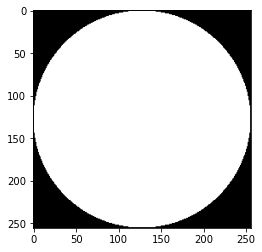

(256, 256)


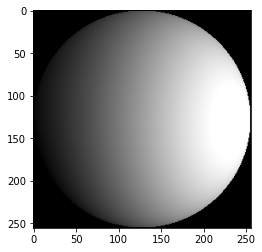

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch as th

def get_shading(normal, SH):
    '''
        get shading based on normals and SH
        normal is Nx3 matrix
        SH: 9 x m vector
        return Nxm vector, where m is the number of returned images
    '''
    sh_basis = SH_basis(normal)
    shading = np.matmul(sh_basis, SH)
    #shading = np.matmul(np.reshape(sh_basis, (-1, 9)), SH)
    #shading = np.reshape(shading, normal.shape[0:2])
    return shading

def SH_basis(normal):
    '''
        get SH basis based on normal
        normal is a Nx3 matrix
        return a Nx9 matrix
        The order of SH here is:
        1, Y, Z, X, YX, YZ, 3Z^2-1, XZ, X^2-y^2
    '''
    numElem = normal.shape[0]

    norm_X = normal[:,0]
    norm_Y = normal[:,1]
    norm_Z = normal[:,2]

    sh_basis = np.zeros((numElem, 9))
    att= np.pi*np.array([1, 2.0/3.0, 1/4.0])
    sh_basis[:,0] = 0.5/np.sqrt(np.pi)*att[0]

    sh_basis[:,1] = np.sqrt(3)/2/np.sqrt(np.pi)*norm_Y*att[1]
    sh_basis[:,2] = np.sqrt(3)/2/np.sqrt(np.pi)*norm_Z*att[1]
    sh_basis[:,3] = np.sqrt(3)/2/np.sqrt(np.pi)*norm_X*att[1]

    sh_basis[:,4] = np.sqrt(15)/2/np.sqrt(np.pi)*norm_Y*norm_X*att[2]
    sh_basis[:,5] = np.sqrt(15)/2/np.sqrt(np.pi)*norm_Y*norm_Z*att[2]
    sh_basis[:,6] = np.sqrt(5)/4/np.sqrt(np.pi)*(3*norm_Z**2-1)*att[2]
    sh_basis[:,7] = np.sqrt(15)/2/np.sqrt(np.pi)*norm_X*norm_Z*att[2]
    sh_basis[:,8] = np.sqrt(15)/4/np.sqrt(np.pi)*(norm_X**2-norm_Y**2)*att[2]
    return sh_basis



img_size = 256
x = np.linspace(-1, 1, img_size)
z = np.linspace(1, -1, img_size)
x, z = np.meshgrid(x, z)

mag = np.sqrt(x**2 + z**2)
valid = mag <=1
y = -np.sqrt(1 - (x*valid)**2 - (z*valid)**2)
x = x * valid
y = y * valid
z = z * valid
normal = np.concatenate((x[...,None], y[...,None], z[...,None]), axis=2)

print(normal.shape)
print("VALID : ", valid.shape)
plt.imshow(np.stack([valid, valid, valid], axis=-1).astype(np.uint8)*255)
plt.show()
normal = np.reshape(normal, (-1, 3))

sh = np.array([1.084125496282453138e+00,
            -4.642676300617166185e-01,
            2.837846795150648915e-02,
            6.765292733937575687e-01,
            -3.594067725393816914e-01,
            4.790996460111427574e-02,
            -2.280054643781863066e-01,
            -8.125983081159608712e-02,
            2.881082012687687932e-01])

sh = sh[0:9]
sh = sh * 0.7

# rendering half-sphere
sh = np.squeeze(sh)
shading = get_shading(normal, sh)
value = np.percentile(shading, 95)
ind = shading > value
shading[ind] = value
shading = (shading - np.min(shading))/(np.max(shading) - np.min(shading))
shading = (shading *255.0).astype(np.uint8)
shading = np.reshape(shading, (256, 256))
shading = shading * valid
print(shading.shape)
shading = np.stack([shading, shading, shading], axis=-1)
plt.imshow(shading)
plt.show()

In [3]:
import sys, glob
import pandas as pd
from collections import defaultdict
import torch as th
pi = np.pi
constant_factor = th.tensor([1/np.sqrt(4*pi), ((2*pi)/3)*(np.sqrt(3/(4*pi))), ((2*pi)/3)*(np.sqrt(3/(4*pi))),
                    ((2*pi)/3)*(np.sqrt(3/(4*pi))), (pi/4)*(3)*(np.sqrt(5/(12*pi))), (pi/4)*(3)*(np.sqrt(5/(12*pi))),
                    (pi/4)*(3)*(np.sqrt(5/(12*pi))), (pi/4)*(3/2)*(np.sqrt(5/(12*pi))), (pi/4)*(1/2)*(np.sqrt(5/(4*pi)))]).float()


def add_SHlight(normal_images, sh_coeff):
    '''
        sh_coeff: [bz, 9, 3]
    '''
    N = normal_images
    sh = th.stack([
            N[:,0]*0.+1., N[:,0], N[:,1], \
            N[:,2], N[:,0]*N[:,1], N[:,0]*N[:,2], 
            N[:,1]*N[:,2], N[:,0]**2 - N[:,1]**2, 3*(N[:,2]**2) - 1
            ], 
            1) # [bz, 9, h, w]
    sh = sh*constant_factor[None,:,None,None]
    shading = th.sum(sh_coeff[:,:,:,None,None]*sh[:,:,None,:,:], 1) # [bz, 9, 3, h, w]  
    return shading

def load_params(path, params_key):

    anno_path = glob.glob(f'{path}/*.txt')
    params = {}
    for k in params_key:
        for p in anno_path:
            # Params
            if k in p:
                print(f'Key=> {k} : Filename=>{p}')
                params[k] = read_params(path=p)

    params_s = swap_key(params)

    all_params = []
    for img_name in params_s:
        each_img = []
        for k in params_key:
            each_img.append(params_s[img_name][k])
        all_params.append(np.concatenate(each_img))
    all_params = np.stack(all_params)

    return params_s, all_params

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

# Load params
params_key = ['light']
params_train, params_train_arr = load_params(path="/data/mint/ffhq_256_with_anno/params/train/", params_key=params_key)
params_valid, params_valid_arr = load_params(path="/data/mint/ffhq_256_with_anno/params/valid/", params_key=params_key)


Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-light-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt


NORMAL :  (1, 3, 256, 256)
VALID :  (256, 256)


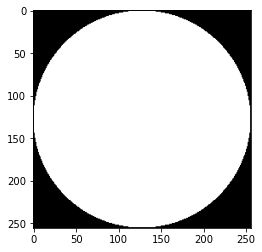

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


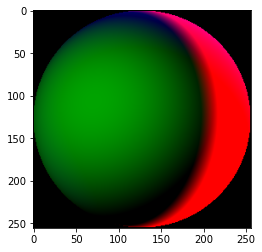

In [33]:
img_size = 256
x = np.linspace(-1, 1, img_size)
z = np.linspace(1, -1, img_size)
x, z = np.meshgrid(x, z)

mag = np.sqrt(x**2 + z**2)
valid = mag <=1 # Unit circle
y = -np.sqrt(1 - (x*valid)**2 - (z*valid)**2)
x = x * valid
y = y * valid
z = z * valid
normal = np.concatenate((x[...,None], y[...,None], z[...,None]), axis=2)
normal = np.transpose(normal, (2, 0, 1))[None, :]

print("NORMAL : ", normal.shape)
print("VALID : ", valid.shape)
plt.imshow(np.stack([valid, valid, valid], axis=-1).astype(np.uint8)*255)
plt.show()


sh_deca = params_valid_arr.reshape(-1, 3, 9)

idx=36
shading = add_SHlight(normal_images=th.tensor(normal), sh_coeff=th.tensor(sh_deca[idx].T)[None, ...]).cpu().numpy()
value = np.percentile(shading, 95)
ind = shading > value
shading[ind] = value
shading = np.transpose(shading, (0, 2, 3, 1))
# shading = (shading - np.min(shading))/(np.max(shading) - np.min(shading))
# shading = (shading*255).astype(np.uint8)
shading = shading * valid[..., None]
plt.imshow(shading[0])
plt.show()

In [19]:
import numpy as np 
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()

x = params_valid_arr[0].reshape(9, 3)
y = params_valid_arr[0].reshape(3, 9).T
# print(np.sum(x**2, axis=1))
# print(np.sum(y**2, axis=1))
vector_plot(params_valid_arr[12].reshape(9, 3).tolist())
vector_plot(params_valid_arr[12].reshape(3, 9).T.tolist())

In [34]:
import os, sys
import cv2
import numpy as np
from time import time
import argparse

fi = open("/data/supasorn/DECA/CelebAMask-HQ-light-anno.txt", "r")


cluster = 5
outs = [0] * cluster
ws = [0] * cluster
means = []
for i in range(cluster):
  chunk = 2.0 / cluster
  pos = chunk /2 + chunk * i - 1
  means.append(pos)

def gaussian(v, m, c):
  return np.exp(-(v-m)**2 / (2*c*c))
for i, l in enumerate(fi.readlines()):
  print(i)
  sp = l.split(" ")
  light = np.array([float(x) for x in sp[1:]])

  img = cv2.imread("/home/konpat/datasets/CelebAMask-HQ/CelebA-HQ-img/" + sp[0]) / 255.0
  s = np.mean(light[6:9])

  for j in range(cluster):
    w = gaussian(s, means[j], 0.2)
    outs[j] += img * w 
    ws[j] += w
  if i == 3000:
    break

for j in range(cluster):
  outs[j] /= ws[j]

fi.close()
cv2.imwrite("light2.jpg", np.concatenate(outs, 1) * 255)

FileNotFoundError: [Errno 2] No such file or directory: '/data/supasorn/DECA/CelebAMask-HQ-light-anno.txt'